# Measuring NO2 concentrations

One of the goals of AgriDataValue is monitoring different kinds of emissions through the use of multispectral Earth Observation Data. In this example, we utilize the Sentinel-5P Satellite and it's TROPOMI sensor to measure N02 emissions across Europe with the use of Sentinel Hub deployment on Copernicus Space Data System.  This notebook serves as a proof of concept example of what can be achieved with the ADV Data Capturing Toolbox. 

Nitrogen dioxide is primarily produced by the burning of fossil fuels. High concentration of Nitrogen dioxide are widely known to cause inlammation of the airways, with long-term exposure leading to respiratory problems such as asthma and bronchitis. 

Areas with high-density road networks close to large populations are most at risk of over-exposure. For thise with pre-existing conditions, along with children and the elderly, this risk is more pronounced. Therefore, regular monitoring of Nitrogen dioxide concentrations is essential for avoiding health risks and keepint track of pollution.
The main objective of the Copernicus Sentinel-5P mission is to perform atmospheric measurements with high spatio-temporal resolution, to be used for air quality, ozone & UV radiation, and climate monitoring & forecasting.

Sources: https://www.aeroqual.com/measurements/nitrogen-dioxide, 
https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p


## Outline

This notebook analyses air pollution in Europe using the TROPOMI sensor on the Sentinel 5P satellite. This notebook aims to provide data to answer the following questions:

- What is the spatial distribution of NO2 concentration in Europe
- How does the NO2 concentration vary over a year
- Which European capitals are most affected by NO2 emissions

and also to demonstrate the capabilties of the AgriDataValue Data Capturing Toolbox to efficeintly retrieve and analyse various kinds of data. 

## Used tools and features

To carry out these analyses we will cover a few different concepts and features available of Sentinel Hub deployment on the Copernicus Dataspace Ecosystem:

- Downloading of Raw data using custom resolutions and bounding boxes
- Calculation of monthly mosaics on the fly in the cloud
- Direct access to timeseries data for geometries through the statistical API
- The popular [pandas](https://pandas.pydata.org/) Python library to analyse tabular data

In [1]:
import getpass
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import rasterio.plot
import seaborn as sns
from rasterio import features

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubRequest,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    SHConfig,
)

### Credentials

A CDSE account needs to be [created](https://identity.dataspace.copernicus.eu/auth/realms/CDSE/login-actions/registration?client_id=account-console&tab_id=QlP9cVAnpAs) first. Registration is open and each user gets a certain amount of monthly processing units for free. Additional processing units can be purchased on request. 


To obtain your `client_id` & `client_secret` you need to navigate to your [CDSE Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/).


In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevent [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the package for accessing Copernicus Data Space Ecosystem data collections. This is useful as changes to the the config class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook. 

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [2]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `profile_name`.

In [2]:
config = SHConfig("cdse")

### Analysing Spatial Distribution

Let's first get an overview of our study area, which is most of mainland Europe. To get this overview we first define an evalscript. An evalscript is a piece of javascript code which specifies how each pixel should be handled. For the first one we just define the input band that we want to look at, which is `NO2` and return that band immediately, without carrying out any more calculations before the data is returned to us.

For more information on evalscripts have a look at the [documentation](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html).

```js
//VERSION=3
function setup() {
   return {
    input: ["NO2"], // This specifies the bands that are looked at
    output: { 
      bands: 1,
      // This specifies in which data type the values will be returned
      sampleType: "FLOAT32"
    },
    // Will make a simple mosaic, taking the most recent tiles to fill the bounding box
    mosaicking: "SIMPLE"
  };
}

function evaluatePixel(samples) {
    // Here we could do more calculations which are applied to each pixel, 
    // but for now let's just return the value 
   return [samples.NO2] 
}
```

In [3]:
# We also need to define the evalscript as a Python variable
evalscript_raw = """
//VERSION=3
function setup() {
   return {
    input: ["NO2"], // This specifies the bands that are looked at
    output: {
      bands: 1,
      // This specifies in which data type the values will be returned
      sampleType: "FLOAT32"
    }
  };
}

function evaluatePixel(samples) {
    // Here we could do more calculations which are applied to each pixel,
    // but for now let's just return the value
   return [samples.NO2]
}
"""

With the evalscript we can now make a request for data.

The request will take care of a lot of things for us. It will return our the data in our specified resolution and bounding box, for our specified time range and it will automatically mosaic multiple tiles together to fill the entire bounding box.

In [21]:
bbox_europe = BBox([-12.30, 34.59, 32.52, 63.15], crs=CRS.WGS84).transform(CRS(3857))
# This is defining the data we will use.
# You can list all available data collections with `DataCollection.get_available_collections()`.
data_5p = DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)

request_raw = SentinelHubRequest(
    evalscript=evalscript_raw,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2023-01-01", "2023-05-26"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox_europe,
    # Resolution is defined in units of the bbox crs! Be careful with WGS84 since this will be in degrees!
    # Since we have defined our bounding box in Web mercator the resolution is in meters.
    resolution=(5500, 3500),
    config=config,
    data_folder="./data",  # We save the data in a specified folder
)

After we've defined the request, we can get the data:

In [22]:
raw_data = request_raw.get_data(save_data=True)

Now we define a function which plots the data of the request together with the borders of the European countries, taken from the natural earth dataset.

In [6]:
countries = (
    gpd.read_file("./data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
    .to_crs(3857)
    .cx[bbox_europe.min_x : bbox_europe.max_x, bbox_europe.min_y : bbox_europe.max_y]
    .reset_index(drop=True)
)
countries = countries[["ADMIN", "geometry"]]


def plot_request(request, bbox, title=""):
    image_path = Path(request.data_folder) / request.get_filename_list()[0]
    with rasterio.open(image_path) as raster:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim([bbox.min_x, bbox.max_x])
        ax.set_ylim([bbox.min_y, bbox.max_y])
        ax.set_title(title)
        rasterio.plot.show(raster, ax=ax)
        countries.plot(ax=ax, facecolor="none", edgecolor="black")

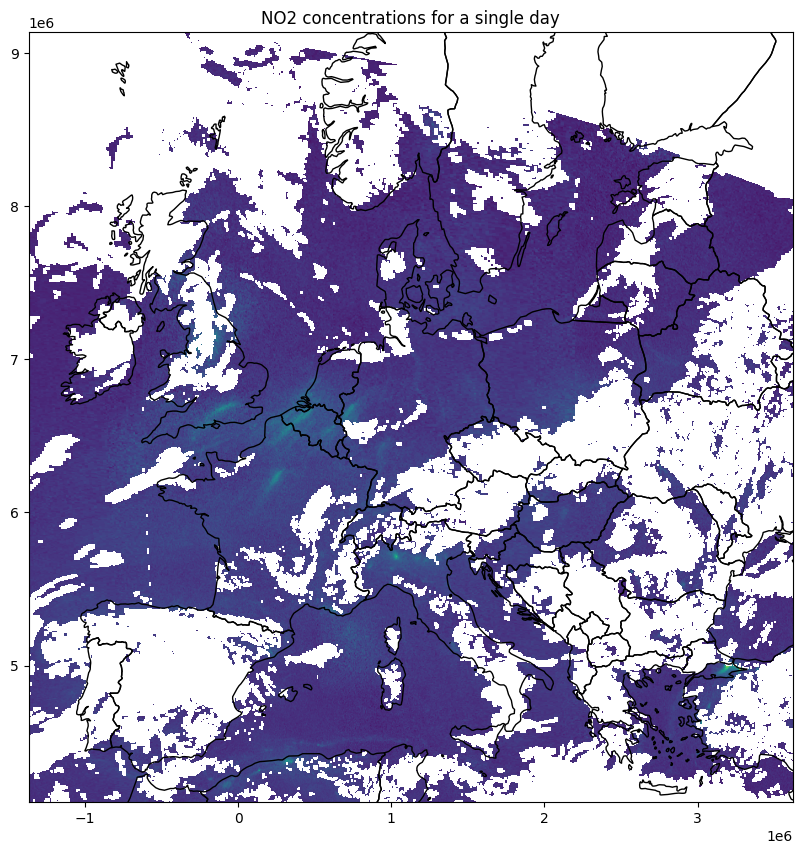

In [7]:
plot_request(request_raw, bbox_europe, "NO2 concentrations for a single day")

We can see here that even though the data is already mosaiced together, filling the entire bounding box, we do not have data everywhere since Tropomi does have a bunch of missing data per acquisition depending on atmospheric conditions. 

With this image we can already see some patterns but let's try to get a more representative image and take the mean of the NO2 values over an entire month to get a more complete picture.

To do this we do not have to download all of the data for an entire month, instead we can extend our evalscript so that the mean value for a month is calculated in the cloud for us. Doing it like this saves us a bunch of time downloading all images. So let's have a look at the updated evalscript:

The most important thing that changed is that we now changed the mosaicking input to ORBIT. This gives us all acquisitions for a time series to calculate values from. In the input we also have added `dataMask` as a band. This will tell us, if the NO2 band has data or not. We are using this to remove acquisitions without data from our calculation.

In our `evaluatePixel` function we have added two more steps. The first one is to filter out all acquisitions which do not have data with the `isClear()` function. After we have filtered the time series we can calculate the mean of all values using the `sum()` function and the length of the clear timeseries.

In the end we return the mean value we have calculated.

```js
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].NO2;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
```

In [8]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].NO2;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
"""

In [9]:
request_monthly = SentinelHubRequest(
    evalscript=evalscript_mean_mosaic,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2022-12-01", "2023-01-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox_europe,
    resolution=(5000, 3500),
    config=config,
    data_folder="./data",
)

We now made a request for an entire month of data, for December of 2022. Other than that nothing much changed in the request.

In [10]:
mean_data = request_monthly.get_data(save_data=True)

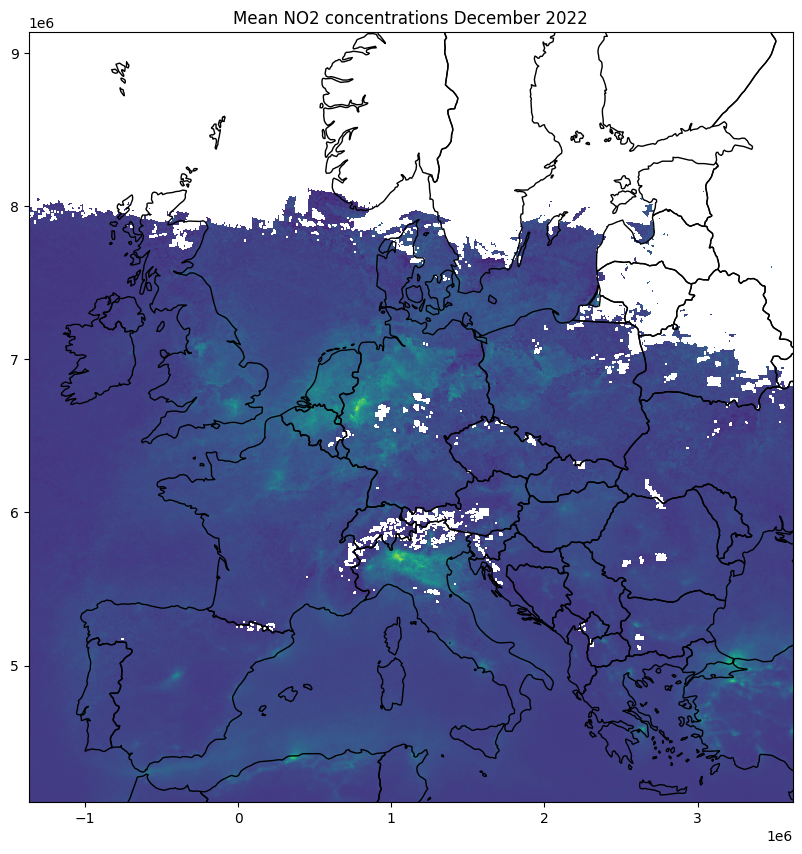

In [11]:
plot_request(request_monthly, bbox_europe, "Mean NO2 concentrations December 2022")

The alps and the northern countries still do not have all data due to snow cover and low sun angles, however most of the rest of Europe is now covered by data.

We can clearly see NO2 hot spots around developed areas, like the Po Valley in Italy and the Ruhr area in Germany. You can also clearly make out the effect of some cities, like Istanbul and Madrid.

Doing it the traditional way, you would have to download at least 18GB of data to be able to have all the data necessary to start computing the mosaic. In our case we just need to download the finished mosaic for our area of interest which has a size of 1.3 MB.

### Analysing European countries

Now let's look at the distribution of values per country to see which countries had the highest average NO2 values in the month. 

To do this we rasterize all countries in our area of interest. We do this so that we can select all array values which are covered by a certain country.

In [23]:
countries["ID"] = countries.index

image_path = Path(request_monthly.data_folder) / request_monthly.get_filename_list()[0]
with rasterio.open(image_path) as src:
    affine = src.transform
# convert gpd Dataframe to format accepted by rasterize
geo_iter = list(countries[["geometry", "ID"]].itertuples(index=False, name=None))
# This call is converting the array into a raster with the same size as our NO2 raster
country_array = features.rasterize(geo_iter, transform=affine, out_shape=mean_data[0].shape, fill=-1)

Now we define two helper functions which get all NO2 values in a country and another function which calcuates the mean of those values.

In [24]:
def get_array(country_id):
    return mean_data[0][country_array == country_id]


def get_mean(country_id):
    return np.nanmean(get_array(country_id))

This function is then applied to the countries dataframe, to fill a new column `mean` which holds the mean NO2 values per country.

In [25]:
countries["mean"] = countries.apply(lambda x: get_mean(x["ID"]), axis=1)

/var/folders/t3/mptw_hbn6tjdynvgglr72tdw0000gn/T/ipykernel_52903/2868920507.py:6: RuntimeWarning: Mean of empty slice
  return np.nanmean(get_array(country_id))


We can then sort by that mean value and have a look at the countries with the highest mean.

In [26]:
sorted_df = countries.sort_values("mean", ascending=False)
sorted_df.head(10)

,ADMIN,geometry,ID,mean
20,Netherlands,"MULTIPOLYGON (((667242.940 6577267.510, 655945...",20,0.000108
48,Belgium,"POLYGON ((470455.301 6689943.442, 479173.878 6...",48,0.000099
40,Estonia,"MULTIPOLYGON (((3044805.494 7868837.787, 30419...",40,0.000077
36,Germany,"MULTIPOLYGON (((1060209.439 6028063.653, 10408...",36,0.000065
27,Luxembourg,"POLYGON ((680886.100 6467256.661, 679972.933 6...",27,0.000063
32,Italy,"MULTIPOLYGON (((781584.581 5768463.580, 785443...",32,0.000054
14,San Marino,"POLYGON ((1389852.107 5450198.738, 1383296.868...",14,0.000049
30,Latvia,"POLYGON ((2960380.966 7492512.846, 2954738.894...",30,0.000049
1,Jersey,"POLYGON ((-224715.351 6314191.162, -223742.393...",1,0.000047
24,Monaco,"POLYGON ((828069.165 5426902.987, 821285.634 5...",24,0.000047


For the 5 countries with the highest mean we are then plotting a boxplot of NO2 values. 

In [27]:
# get the country ids with the 5 highest mean values
n_countries = 5
country_ids = list(sorted_df["ID"][:n_countries])
country_names = list(sorted_df["ADMIN"][:n_countries])

/var/folders/t3/mptw_hbn6tjdynvgglr72tdw0000gn/T/ipykernel_52903/1319966017.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(country_names);


Text(0.5, 1.0, 'Distribution of NO2 values in countries')

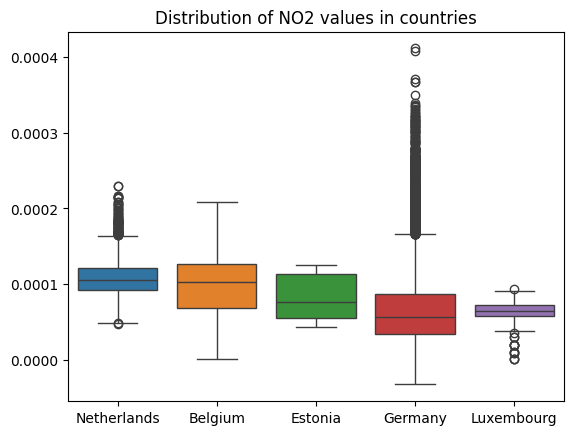

In [28]:
ax = sns.boxplot(data=[get_array(country_id) for country_id in country_ids])
ax.set_xticklabels(country_names)
ax.set_title("Distribution of NO2 values in countries")

From this we can see that even though the mean of values in Germany is the 4th lowest, of the 5 countries it has the absolute highest values. We can also see that Belgium and Germany both have qutie the large variance in NO2 values, with some areas of low NO2 concentration and some areas quite high concentrations.

### Analysing EU Capitals

Now we want to take a look at EU capitals specifically. For this more focused analysis we want to analyse time series data. To do this we are taking advantage of another API capability, the [Statistical API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html).

Even for the previous analysis of European countries, if we were not interested at all in the spatial distribution of data and only interested in statistics for certain geometries, the statistical API would have been the perfect fit. It removes the need to download a lot of data to calculate statistics for areas. Instead it does all of the calculation of statistics like mean, max, min and standard deviation in the cloud and in the end only sends those values. 

Another capability of the API is the easy chunking in regular intervals, which we will be using to make the time series.

But let's first import the EU capitals:

In [29]:
# load capitals
capitals = gpd.read_file("./data/eu_capitals.geojson")

We can also add a custom point so that we can later compare it to the European capitals. We have selected Faro in Portugal, which is supposed to be one of the cities in the EU with the [cleanest air](https://www.eea.europa.eu/themes/air/urban-air-quality/european-city-air-quality-viewer).

In [30]:
lat = 38.02
lon = -7.93
custom_point = "Faro"

extra_point = gpd.GeoDataFrame(
    [custom_point],
    columns=["name"],
    geometry=gpd.points_from_xy([lat], [lon], crs=4326),
)
capitals = pd.concat([capitals, extra_point])

In the Process API examples, we have seen how to obtain satellite imagery. Statistical API can be used in a very similar way. The main difference is that the results of Statistical API are aggregated statistical values of satellite data instead of entire images. In many use cases, such values are all that we need. By using Statistical API we can avoid downloading and processing large amounts of satellite data.

All general rules for building evalscripts apply. However, there are some specifics when using evalscripts with the Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical/Examples.html#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

In [20]:
evalscript_stat = """
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: [{
          id: "default",
          bands: ["NO2"],
          sampleType: "FLOAT32"
        },
        {
          id: "dataMask",
          bands: 1,
        }]
    };
}

function evaluatePixel(samples) {
    const statsVal = isFinite(samples.NO2) ? samples.NO2 : NaN;
    return {default: [statsVal], dataMask: [samples.dataMask]}
}
"""

Now we define the Statistical API request, for that we first define an aggregation. Here we define the time range we are interesed in. In this case it is one year of data, all of 2022. We then define the aggregation interval, this defines how many days are aggregated. 

Since Sentinel 5P has a very high revisit rate we can define a temporal resolution of one day. However we could just as easily make a time series of weekly or monthly values just by changing the aggregation interval to `P1W` or `P1M` respectively.

The size is set to 1 by 1 pixel since Sentinel 5P pixels are quite large and we are only intersted in point data for the capitsls.

In [31]:
aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript_stat,
    time_interval=("2022-01-01", "2023-01-01"),
    aggregation_interval="P2D",
    size=(1, 1),
)

input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)
)

We then create one request for each capital city. Instead of doing it like this we could also use the [Batch Statistical API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/BatchStatistical.html) which is designed to calculate statistics for many polygons efficiently. 

This list of requests is then downloaded in parallel.

To speed running this cell up a bit we are only selecting the capitals of the four countries with the highest NO2 concentrations in the first analysis. This will show us if the high concentration also apply to the capital of that country and if the high concentrations are present all throughout the year.

It is however definitely possible to also run the next cell for all capitals.

In [32]:
capitals.geometry = capitals.to_crs(3857).buffer(2000)
to_get = ["Amsterdam", "Brussels", "Tallinn", "Berlin", custom_point]
selected_capitals = capitals.loc[capitals["name"].isin(to_get)]

requests = []

for geo_shape in selected_capitals.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        config=config,
        bbox=BBox(geo_shape.bounds, crs=selected_capitals.crs),
    )
    requests.append(request)

download_requests = [request.download_list[0] for request in requests]
client = SentinelHubStatisticalDownloadClient(config=config)
pollution_stats = client.download(download_requests, max_threads=5, show_progress=True)

  0%|          | 0/5 [00:00<?, ?it/s]

You get back a json response with all the statistical values for the area. 

In [ ]:
pollution_stats[0]

Due to the structure of the json response it is hard to do any analysis directly with the response. Because of that we want to transform that data to a pandas dataframe. In the next cell we build the dataframe from the request output.

In [34]:
no2_dfs = [pd.json_normalize(stats["data"]) for stats in pollution_stats]
# Add name of the capital to the corresponding data
for df, capital in zip(no2_dfs, selected_capitals.name):
    df["name"] = capital
# Build one dataframe out of the many seperate ones
no2_df = pd.concat(no2_dfs, ignore_index=True)
# Simplify the column names
stat_cols = [col for col in no2_df.columns if "stats" in col]
# Convert to numeric
no2_df[stat_cols] = no2_df[stat_cols].apply(pd.to_numeric, errors="coerce")
no2_df = no2_df.rename(columns=lambda x: x.split(".")[-1])
no2_df["month"] = no2_df["from"].astype("datetime64[ns, UTC]").dt.month
no2_df.to_csv("./data/no2_capitals_timeseries.csv")
no2_df

,from,to,min,max,mean,stDev,sampleCount,noDataCount,name,month
0,2022-01-01T00:00:00Z,2022-01-03T00:00:00Z,0.000045,0.000045,0.000045,0.0,1,0,Amsterdam,1
1,2022-01-03T00:00:00Z,2022-01-05T00:00:00Z,0.000041,0.000041,0.000041,0.0,1,0,Amsterdam,1
2,2022-01-05T00:00:00Z,2022-01-07T00:00:00Z,NaN,NaN,NaN,NaN,1,1,Amsterdam,1
3,2022-01-07T00:00:00Z,2022-01-09T00:00:00Z,NaN,NaN,NaN,NaN,1,1,Amsterdam,1
4,2022-01-09T00:00:00Z,2022-01-11T00:00:00Z,0.000224,0.000224,0.000224,0.0,1,0,Amsterdam,1
...,...,...,...,...,...,...,...,...,...,...
903,2022-12-21T00:00:00Z,2022-12-23T00:00:00Z,NaN,NaN,NaN,NaN,1,1,Faro,12
904,2022-12-23T00:00:00Z,2022-12-25T00:00:00Z,NaN,NaN,NaN,NaN,1,1,Faro,12
905,2022-12-25T00:00:00Z,2022-12-27T00:00:00Z,NaN,NaN,NaN,NaN,1,1,Faro,12
906,2022-12-27T00:00:00Z,2022-12-29T00:00:00Z,NaN,NaN,NaN,NaN,1,1,Faro,12


With this dataframe we can now do analysis. To give an example we are looking at the time series for a few different capital cities.

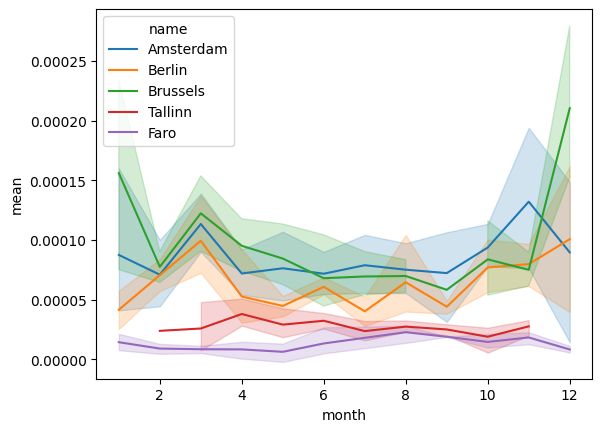

In [35]:
# no2_df = pd.read_csv("./data/no2_capitals_timeseries.csv")

sns.lineplot(
    data=no2_df,
    x="month",
    y="mean",
    hue="name",
);

This shows us that for most cities the NO2 concentration is seasonal, with higher values in winter than in Summer. Amsterdam, Berlin and Brussels all share quite similar temporal patterns. Tallinn on the other hand has much lower NO2 concentration throughout and Faro is consistently below the capitals. 

## Summary

In this notebook we showcase the capabilties of Sentinel Hub on CDSE to efficiently retrieve, visualize and analyse the N02 data from the Copernicus Sentinel-5P satellite. This serves as an example of AgriDataValue Data Capturing Toolbox and demonstrates how parameters can be retrieved in order to use them in the FDML and XAI components of AgriDataValue. Similar approaches can be used to monitor a variety of different parameters and indicators and to extract information from satellite and other derived imagery. 